In [1]:
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
import pickle

In [4]:
df = pd.read_csv("model/final_dataset_form.csv")

In [5]:
df.head()

,Unnamed: 0,Dependent-Company Status,year of founding,Internet Activity Score,Focus functions of company,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Amount,...,Entertainment,Healthcare,Energy,Search,Food & Beverages,Music,Publishing,Gaming,Email,Career / Job Search
0,0,Success,NaN,-1.0,operation,3.0,0.0,No,NaN,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Success,2011.0,125.0,"Marketing, sales",NaN,NaN,No,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Success,2011.0,455.0,operations,14.0,0.0,No,12/1/2011,2350000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Success,2009.0,-99.0,Marketing & Sales,45.0,10.0,No,6/20/2009,10250000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Success,2010.0,496.0,Marketing & Sales,39.0,3.0,No,4/1/2010,5500000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# We'll drop both the duplicated index column and the year of founding column, since it's already represented by the Est. founding date
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('year of founding', axis=1, inplace=True)

In [7]:
# Separate our X and Y
X = df.drop('Dependent-Company Status', axis=1)
y = df['Dependent-Company Status']

In [20]:
# Split the data
X_train_l, X_test, y_train_l, y_test = train_test_split(X, y, train_size=0.85)

In [9]:
parameters = {'xgbclassifier__nthread':[4], #when use hyperthread, xgboost may become slower
              'xgbclassifier__objective':['binary:logistic'],
              'xgbclassifier__learning_rate': [0.05], #so called `eta` value
              'xgbclassifier__max_depth': [6],
              'xgbclassifier__min_child_weight': [11],
              'xgbclassifier__silent': [1],
              'xgbclassifier__subsample': [0.8],
              'xgbclassifier__colsample_bytree': [0.7],
              'xgbclassifier__n_estimators': [5], #number of trees, change it to 1000 for better results
              'xgbclassifier__missing':[-999],
              'xgbclassifier__seed': [1337]}

In [10]:
# Make the pipeline
pipeline = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier()
)

In [11]:
grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring='roc_auc')

In [12]:
grid.fit(X_train_l, y_train_l)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
          

In [13]:
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid.best_params_))
print("Best score is {}".format(grid.best_score_))

Tuned Decision Tree Parameters: {'xgbclassifier__colsample_bytree': 0.7, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 6, 'xgbclassifier__min_child_weight': 11, 'xgbclassifier__missing': -999, 'xgbclassifier__n_estimators': 5, 'xgbclassifier__nthread': 4, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__seed': 1337, 'xgbclassifier__silent': 1, 'xgbclassifier__subsample': 0.8}
Best score is 0.9410295882278641


In [14]:
# Make the pipeline
pipeline_final = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.05, max_depth = 6, min_child_weight = 11, missing = -999, n_estimators=1000, nthread=4, seed=1337, silent=0, subsample=0.8)
)

In [15]:
pipeline_final.fit(X_train_l, y_train_l)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Focus functions of company',
                                      'Has the team size grown',
                                      'Est. Founding Date',
                                      'Country of company',
                                      'Presence of a top angel or venture fund '
                                      'in previous round of investment',
                                      'Number of  Sales Support material',
                                      'Worked in top companies',
                                      'Average size of companies worked for in '
                                      'the past',
                                      'Have been part of startups in the past?'...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytr

In [21]:
# First we'll look at the training accuracy
print("Model's accuracy on training data: ", pipeline_final.score(X_train_l, y_train_l))
# Now, we'll see our valiation accuracy
print("Model's accuracy on training data: ", pipeline_final.score(X_test, y_test))

Model's accuracy on training data:  0.942643391521197
Model's accuracy on training data:  0.9577464788732394


<Figure size 576x576 with 0 Axes>

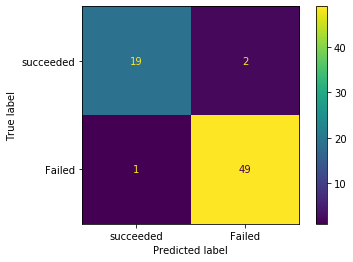

In [22]:
# Plot a confusion matrix
fig, ax = plt.subplots(1,1, figsize=(8,8))

plot_confusion_matrix(pipeline_final, X_test, y_test,
                      display_labels=['succeeded', 'Failed'],
                      )

fig.clf()

In [23]:
# See our precision and recall
y_pred = pipeline_final.predict(X_test)
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Failed       0.95      0.90      0.93        21
     Success       0.96      0.98      0.97        50

    accuracy                           0.96        71
   macro avg       0.96      0.94      0.95        71
weighted avg       0.96      0.96      0.96        71



In [25]:
pipeline_final.fit(X, y)
filename = 'new_pipeline.joblib'
pickle.dump(pipeline_final, open(filename, 'wb'))